In [2]:
# Loading data from Google Drive
from google.colab import drive
drive.mount('/content/drive/')
#PyTorch lib
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
#Tools lib
import numpy as np
import cv2
import random
import time
import os
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import sys
from google.colab.patches import cv2_imshow
from matplotlib.colors import LinearSegmentedColormap

root_path = '/content/drive/MyDrive/DeRaindrop-master/'
#model_path = '/content/drive/MyDrive/DeRaindrop-master/models'


sys.path.append(root_path)
#sys.path.append(model_path)

from predict import align_to_four

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#Set iteration time
ITERATION = 4

#Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.det_conv0 = nn.Sequential(
            nn.Conv2d(4, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.conv_i = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_f = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_g = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Tanh()
            )
        self.conv_o = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.det_conv_mask = nn.Sequential(
            nn.Conv2d(32, 1, 3, 1, 1),
            )


    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        mask = Variable(torch.ones(batch_size, 1, row, col)).cuda() / 2.
        h = Variable(torch.zeros(batch_size, 32, row, col)).cuda()
        c = Variable(torch.zeros(batch_size, 32, row, col)).cuda()
        mask_list = []
        for i in range(ITERATION):
            x = torch.cat((input, mask), 1)
            x = self.det_conv0(x)
            resx = x
            x = F.relu(self.det_conv1(x) + resx)
            resx = x
            x = F.relu(self.det_conv2(x) + resx)
            resx = x
            x = F.relu(self.det_conv3(x) + resx)
            resx = x
            x = F.relu(self.det_conv4(x) + resx)
            resx = x
            x = F.relu(self.det_conv5(x) + resx)
            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * F.tanh(c)
            mask = self.det_conv_mask(h)
            mask_list.append(mask)
        return mask_list

In [4]:
def predict(image, model):
    image = np.array(image, dtype='float32')/255.
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :, :, :]
    #print(image.shape)
    image = torch.from_numpy(image)
    image = Variable(image).cuda()

    outs = []
    maps = model(image)
    for i in range(4):
        out = maps[i]
        out = out.cpu().data
        out = out.numpy()
        out = out.transpose((0, 2, 3, 1))
        out = out[0, :, :, :] #*255.
        outs.append(out)
        #print(out)
        #print(out.shape)

    return outs

def run(input, model, save_file_name):
    mask = predict(input, model)[-1]
    # Reshape if necessary
    if mask.shape[2] == 1:
        mask = mask.reshape(mask.shape[0], mask.shape[1])

    # Visualizing the attention map
    plt.imshow(mask, cmap='seismic', interpolation='nearest')
    #plt.colorbar()
    plt.axis('off')
    plt.savefig(save_file_name)
   # plt.show()


In [5]:
def run_4(input, model, save_file_name):
    # Set up a grid of plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    masks = predict(input, model)
    for i, ax in enumerate(axes):
        mask = masks[i]
        # Reshape if necessary
        if mask.shape[2] == 1:
            mask = mask.reshape(mask.shape[0], mask.shape[1])
        ax.imshow(mask, cmap='seismic', interpolation='nearest')
        ax.set_title(f'Attention Map {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_file_name)
    #plt.show()

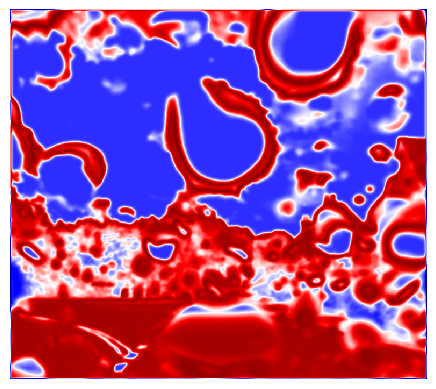

In [7]:
image_list = ['right_1535201300860547.png']#,
              #'right_1535205304003779.png',
             # 'right_1535205669184924.png']

I_list = [align_to_four(cv2.imread(x)) for x in image_list]

epoch_list = [1,15,30,50]
for epoch in epoch_list:
    weights_path = "/content/drive/MyDrive/Qian/attentive_map_training/n4/"+str(epoch-1)+'.pt'
    output_path = "/content/drive/MyDrive/Qian/attentive_map_training/result/epoch"+str(epoch)+'/'
    model = Generator().cuda()
    model.load_state_dict(torch.load(weights_path))
    for i, I in enumerate(I_list):
        save_file_name_1 = output_path+str(i)+'_1.png'
        #save_file_name_4 = output_path+str(i)+'_4.png'
        run(I, model, save_file_name_1)
        #run_4(I, model, save_file_name_4)


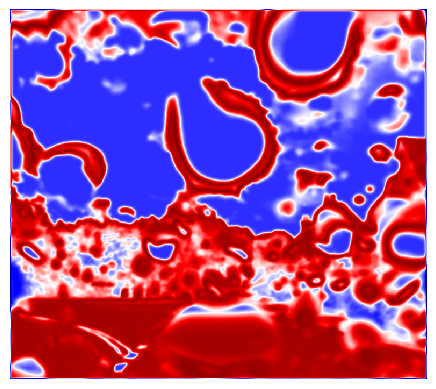

In [13]:
I = align_to_four(cv2.imread('right_1535201300860547.png'))

weights_path = "/content/drive/MyDrive/Qian/attentive_map_training/n4/49.pt"
output_path = "/content/drive/MyDrive/Qian/attentive_map_training/result/epoch1/"
model = Generator().cuda()
model.load_state_dict(torch.load(weights_path))

save_file_name_1 = output_path+'0_1.png'

run(I, model, save_file_name_1)